### Goal is to predict CASE_STATUS variable

#### Data is from https://www.foreignlaborcert.doleta.gov/performancedata.cfm#dis LCA Programs (H-1B, H-1B1, E-3). NAICS data from https://www.census.gov/eos/www/naics/downloadables/downloadables.html

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys 
import os
from scipy import stats
from scipy.stats import norm
plt.style.use('ggplot')
sys.path.append(os.path.abspath("../../shared"))
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
import feature_selection
import helpers
import eda
import preprocessing
%matplotlib inline

In [2]:
emp_raw_data = pd.read_csv('H-1B_Disclosure_Data_FY17.csv', 
                           dtype={'EMPLOYER_PROVINCE': str, 'EMPLOYER_PHONE': str, 'EMPLOYER_PHONE_EXT': str, 'NAICS_CODE': str})
naics_raw_data = pd.read_csv('2017_NAICS_Descriptions.csv')

In [3]:
print(emp_raw_data.shape)
print(naics_raw_data.shape)

(624650, 53)
(2196, 4)


In [4]:
emp_data = emp_raw_data.drop(labels=['Unnamed: 0', 'PUBLIC_DISCLOSURE_LOCATION'], axis=1)
naics_data = naics_raw_data.drop(labels='Unnamed: 0', axis=1)

In [5]:
emp_data.head()

,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,EMPLOYER_BUSINESS_DBA,EMPLOYER_ADDRESS,EMPLOYER_CITY,EMPLOYER_STATE,EMPLOYER_POSTAL_CODE,EMPLOYER_COUNTRY,EMPLOYER_PROVINCE,EMPLOYER_PHONE,EMPLOYER_PHONE_EXT,AGENT_REPRESENTING_EMPLOYER,AGENT_ATTORNEY_NAME,AGENT_ATTORNEY_CITY,AGENT_ATTORNEY_STATE,JOB_TITLE,SOC_CODE,SOC_NAME,NAICS_CODE,TOTAL_WORKERS,NEW_EMPLOYMENT,CONTINUED_EMPLOYMENT,CHANGE_PREVIOUS_EMPLOYMENT,NEW_CONCURRENT_EMPLOYMENT,CHANGE_EMPLOYER,AMENDED_PETITION,FULL_TIME_POSITION,PREVAILING_WAGE,PW_UNIT_OF_PAY,PW_WAGE_LEVEL,PW_SOURCE,PW_SOURCE_YEAR,PW_SOURCE_OTHER,WAGE_RATE_OF_PAY_FROM,WAGE_RATE_OF_PAY_TO,WAGE_UNIT_OF_PAY,H1B_DEPENDENT,WILLFUL_VIOLATOR,SUPPORT_H1B,LABOR_CON_AGREE,WORKSITE_CITY,WORKSITE_COUNTY,WORKSITE_STATE,WORKSITE_POSTAL_CODE,ORIGINAL_CERT_DATE
0,I-200-16055-173457,CERTIFIED-WITHDRAWN,2016-02-24,2016-10-01,H-1B,2016-08-10,2019-08-10,DISCOVER PRODUCTS INC.,NaN,2500 LAKE COOK ROAD,RIVERWOODS,IL,60015,UNITED STATES OF AMERICA,NaN,2244050900,NaN,Y,"ELLSWORTH, CHAD",NEW YORK,NY,ASSOCIATE DATA INTEGRATION,15-1121,COMPUTER SYSTEMS ANALYSTS,522210,1,1,0,0,0,0,0,Y,59197.0,Year,Level I,OES,2015.0,OFLC ONLINE DATA CENTER,65811.0,67320.0,Year,N,N,NaN,Y,RIVERWOODS,LAKE,IL,60015,2016-03-01
1,I-200-16064-557834,CERTIFIED-WITHDRAWN,2016-03-04,2016-10-01,H-1B,2016-08-16,2019-08-16,DFS SERVICES LLC,NaN,2500 LAKE COOK ROAD,RIVERWOODS,IL,60015,UNITED STATES OF AMERICA,NaN,2244050900,NaN,Y,"ELLSWORTH, CHAD",NEW YORK,NY,SENIOR ASSOCIATE,15-2031,OPERATIONS RESEARCH ANALYSTS,522210,1,1,0,0,0,0,0,Y,49800.0,Year,NaN,Other,2015.0,TOWERS WATSON DATA SERVICES 2015 CSR PROFESSIO...,53000.0,57200.0,Year,N,N,NaN,Y,RIVERWOODS,LAKE,IL,60015,2016-03-08
2,I-200-16063-996093,CERTIFIED-WITHDRAWN,2016-03-10,2016-10-01,H-1B,2016-09-09,2019-09-09,EASTBANC TECHNOLOGIES LLC,NaN,1211 31ST ST. NW,WASHINGTON,DC,20007,UNITED STATES OF AMERICA,NaN,2022953000,NaN,Y,"BURKE, KAREN",WASHINGTON,DC,.NET SOFTWARE PROGRAMMER,15-1131,COMPUTER PROGRAMMERS,541511,2,2,0,0,0,0,0,Y,76502.0,Year,Level II,OES,2015.0,OFLC ONLINE DATA CENTER,77000.0,0.0,Year,Y,N,Y,NaN,WASHINGTON,NaN,DC,20007,2016-03-16
3,I-200-16272-196340,WITHDRAWN,2016-09-28,2016-10-01,H-1B,2017-01-26,2020-01-25,INFO SERVICES LLC,NaN,17177 NORTH LAUREL PARK DR,LIVONIA,MI,48152,UNITED STATES OF AMERICA,NaN,7343776007,NaN,N,",",NaN,NaN,PROJECT MANAGER,15-1199,"COMPUTER OCCUPATIONS, ALL OTHER",541511,1,1,0,0,0,0,0,Y,90376.0,Year,Level III,OES,2016.0,OFLC ONLINE DATA CENTER,102000.0,0.0,Year,Y,N,Y,NaN,JERSEY CITY,HUDSON,NJ,07302,NaN
4,I-200-15053-636744,CERTIFIED-WITHDRAWN,2015-02-22,2016-10-02,H-1B,2015-03-01,2018-03-01,BB&T CORPORATION,NaN,223 WEST NASH STREET,WILSON,NC,27893,UNITED STATES OF AMERICA,NaN,2522462031,NaN,Y,"SCOFIELD, EILEEN",ATLANTA,GA,ASSOCIATE - ESOTERIC ASSET BACKED SECURITIES,13-2041,CREDIT ANALYSTS,522110,1,0,0,0,0,1,0,Y,116605.0,Year,Level III,OES,2015.0,OFLC ONLINE DATA CENTER,132500.0,0.0,Year,N,N,NaN,Y,NEW YORK,NEW YORK,NY,10036,2015-02-26


### The naics data will be used to see the industry of the company so as to see which industries get the most H1-B visas certified

In [6]:
naics_data.head()

,Code,Title,Description
0,11,"Agriculture, Forestry, Fishing and HuntingT","The Sector as a Whole\n\nThe Agriculture, Fore..."
1,111,Crop ProductionT,Industries in the Crop Production subsector gr...
2,1111,Oilseed and Grain FarmingT,This industry group comprises establishments p...
3,11111,Soybean FarmingT,See industry description for 111110.
4,111110,Soybean Farming,This industry comprises establishments primari...


In [7]:
#missing_data = preprocessing.percent_missing(emp_data)
#missing_data.head(25)

### Exploratory Analysis

In [8]:
emp_data = emp_data[emp_data['VISA_CLASS'] == 'H-1B']
emp_data = emp_data.drop(labels=['VISA_CLASS'], axis=1)
emp_data = emp_data.reindex_axis(sorted(emp_data.columns), axis=1)

/home/daniel/mlenv/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


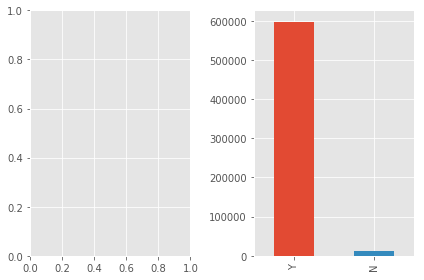

In [9]:
#sns.factorplot(kind='count', x=emp_data1['FULL_TIME_POSITION'])
f, ax = plt.subplots(1,2)
#emp_data[emp_data['FULL_TIME_POSITION'] == 'N']['CASE_STATUS'].value_counts().plot.bar(ax=ax[0], title='Part time position')
#emp_data[emp_data['FULL_TIME_POSITION'] == 'Y']['CASE_STATUS'].value_counts().plot.bar(ax=ax[1], title='Full time position')
emp_data['FULL_TIME_POSITION'].value_counts().plot.bar()
plt.tight_layout()

In [10]:
emp_data['CASE_NUMBER'].head()

0    I-200-16055-173457
1    I-200-16064-557834
2    I-200-16063-996093
3    I-200-16272-196340
4    I-200-15053-636744
Name: CASE_NUMBER, dtype: object

In [11]:
emp_data.columns

Index([u'AGENT_ATTORNEY_CITY', u'AGENT_ATTORNEY_NAME', u'AGENT_ATTORNEY_STATE',
       u'AGENT_REPRESENTING_EMPLOYER', u'AMENDED_PETITION', u'CASE_NUMBER',
       u'CASE_STATUS', u'CASE_SUBMITTED', u'CHANGE_EMPLOYER',
       u'CHANGE_PREVIOUS_EMPLOYMENT', u'CONTINUED_EMPLOYMENT',
       u'DECISION_DATE', u'EMPLOYER_ADDRESS', u'EMPLOYER_BUSINESS_DBA',
       u'EMPLOYER_CITY', u'EMPLOYER_COUNTRY', u'EMPLOYER_NAME',
       u'EMPLOYER_PHONE', u'EMPLOYER_PHONE_EXT', u'EMPLOYER_POSTAL_CODE',
       u'EMPLOYER_PROVINCE', u'EMPLOYER_STATE', u'EMPLOYMENT_END_DATE',
       u'EMPLOYMENT_START_DATE', u'FULL_TIME_POSITION', u'H1B_DEPENDENT',
       u'JOB_TITLE', u'LABOR_CON_AGREE', u'NAICS_CODE',
       u'NEW_CONCURRENT_EMPLOYMENT', u'NEW_EMPLOYMENT', u'ORIGINAL_CERT_DATE',
       u'PREVAILING_WAGE', u'PW_SOURCE', u'PW_SOURCE_OTHER', u'PW_SOURCE_YEAR',
       u'PW_UNIT_OF_PAY', u'PW_WAGE_LEVEL', u'SOC_CODE', u'SOC_NAME',
       u'SUPPORT_H1B', u'TOTAL_WORKERS', u'WAGE_RATE_OF_PAY_FROM',
       u'WA

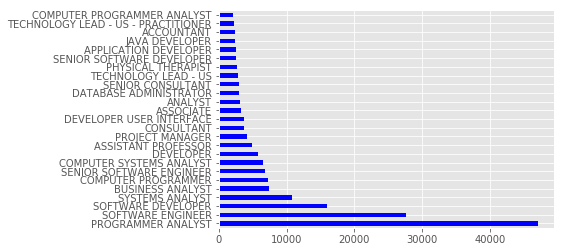

In [12]:
emp_data.JOB_TITLE.value_counts().sort_values(ascending=False).head(25).plot(kind='barh',color='blue');

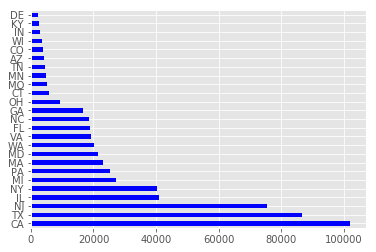

In [13]:
emp_data.EMPLOYER_STATE.value_counts().sort_values(ascending=False).head(25).plot(kind='barh',color='blue');

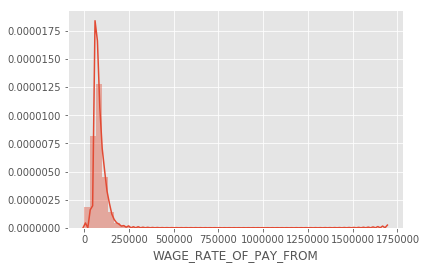

In [14]:
#sns.factorplot(kind='count', data=emp_data, x='')
sns.distplot(emp_data['WAGE_RATE_OF_PAY_FROM'])

In [15]:
emp_data['WAGE_RATE_OF_PAY_FROM'].describe()

count    6.103040e+05
mean     8.243484e+04
std      4.175534e+04
min      0.000000e+00
25%      6.300000e+04
50%      7.579600e+04
75%      9.914400e+04
max      1.688000e+06
Name: WAGE_RATE_OF_PAY_FROM, dtype: float64